# Classifying elliptic curves by complex multiplication

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from tqdm.notebook import *
from math import *
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from helpers import *

In [2]:
df = pd.read_csv("output/dataset_unnormalized.csv")

In [3]:
df.head()

,A2,A3,A5,A7,A11,A13,A17,A19,A23,A29,...,A9901,A9907,A9923,A9929,A9931,A9941,A9949,A9967,A9973,CM
0,0.0,0.0,-4.0,0.0,4.0,0.0,2.0,6.0,-4.0,-10.0,...,70.0,88.0,92.0,102.0,26.0,114.0,-66.0,-152.0,-82.0,0.0
1,0.0,0.0,3.0,-3.0,6.0,-4.0,0.0,2.0,0.0,6.0,...,97.0,-6.0,-100.0,147.0,96.0,29.0,64.0,-116.0,-73.0,0.0
2,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,8.0,0.0,6.0,...,-70.0,134.0,154.0,-10.0,68.0,0.0,22.0,-168.0,194.0,0.0
3,0.0,0.0,0.0,-2.0,6.0,-2.0,4.0,1.0,3.0,-1.0,...,-46.0,-138.0,156.0,111.0,20.0,-138.0,-76.0,41.0,115.0,0.0
4,0.0,1.0,1.0,2.0,5.0,1.0,0.0,-4.0,4.0,2.0,...,87.0,-1.0,36.0,-24.0,-32.0,38.0,-4.0,94.0,18.0,0.0


In [7]:
SOPHIE_GERMAIN = True
if not SOPHIE_GERMAIN:
    X = np.array(df)
    X = np.delete(X, len(X[0])-1, 1)
    Y = np.array(df["CM"])
else:
    indexes=[]
    for x in df.columns.values:
        if x == "CM":
            continue
        if is_sg(int(x[1:])) or is_safe(int(x[1:])):
            indexes.append(x)
    X = np.array(df[indexes])
    Y = np.array(df["CM"])

In [8]:
X.shape

(5000, 278)

In [9]:
Y.shape

(5000,)

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, shuffle = True)

In [27]:
def ma_sampling(x: list, win = 28): # For pretty plots
    assert len(x)>win, "Window too large!"
    cur_sum = sum(x[:win])
    cur_pos = win - 1
    sampled = []
    for i in range(len(x)-win):
        sampled.append(cur_sum/win)
        cur_sum -= x[cur_pos-win]
        cur_pos += 1
        cur_sum += x[cur_pos]
    return sampled

In [12]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float()
        y = Y[i]
        _y = model(x)
        if _y[0] > _y[1]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

## Neural network model

In [ ]:
from torchviz import make_dot
DATA_SIZE = len(X[0])
N_EPOCHS = 2000
N_DISPLAY = 20
SAMPLE_SIZE = 100
A=314
k=4
model = nn.Sequential(
        nn.Linear(DATA_SIZE, A),
        nn.Dropout(0.1),
        nn.Tanh(),
        nn.Linear(A, k*A),
        nn.LeakyReLU(),
        nn.Linear(k*A, k*A),
        nn.ELU(),
        nn.Linear(k*A, k*A),
        nn.LeakyReLU(),
        nn.Linear(k*A, A),
        nn.Tanh(),
        nn.Linear(A, 2),
        nn.Softmax()
)
criterion = nn.CrossEntropyLoss() # The MOST inconvinient criterion ever!
optimizer = optim.SGD(model.parameters(), lr=0.01)
#print("Untrained accuracy(test): %.3f"%acc(X_test, Y_test))
#print("Untrained accuracy(train): %.3f"%acc(X_train, Y_train))
x = torch.tensor(X[0], dtype=torch.double).float()
y = model(x)
make_dot(y)

In [ ]:
losses = []
plotlosses = PlotLosses()
avg_loss_lr = 0.0
avg_accuracy = 0.0
for i in tnrange(N_EPOCHS):
    indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
    sample_x = X_train[indices]
    sample_y = Y_train[indices]
    avg_loss = 0.0
    for j in range(SAMPLE_SIZE):
        x = torch.Tensor(sample_x[j])
        target = torch.Tensor([int(sample_y[j])]).type(torch.LongTensor)
        optimizer.zero_grad()   
        output = model(x)
        output = output.reshape((1,2)).float()
        loss = criterion(output, target)
        avg_loss += float(loss)
        loss.backward()
        optimizer.step()
    avg_loss /= SAMPLE_SIZE
    avg_loss_lr += avg_loss
    #avg_accuracy += acc(X_test, Y_test)
    if i % N_DISPLAY == 0 and i > 0:
        avg_loss_lr /= N_DISPLAY
        #avg_accuracy /= N_DISPLAY
        plotlosses.update({"Loss": avg_loss_lr, "Accuracy": acc(X_test, Y_test)})
        plotlosses.send()
        avg_loss_lr = 0.0
        avg_accuracy = 0.0
    losses.append(avg_loss)

In [ ]:
plt.plot(ma_sampling(losses))
plt.show()

In [ ]:
print("Acc(train): %.3f"%acc(X_train, Y_train))
print("Acc(test): %.3f"%acc(X_test, Y_test))

As it can be seen neural networks are absolutely useless for classifying _~~anything~~_ elliptic curves.

## Naive Bayesian classifier

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
naive_bayes = GaussianNB()
naive_bayes.fit(X_train , Y_train)
Y_predicted = naive_bayes.predict(X_test)
print("Acc: %.3f" % metrics.accuracy_score(Y_predicted , Y_test))

Acc: 0.965


## Convolutional neural network

In [ ]:
model = nn.Sequential(
        nn.Conv1d(1, 1, 64),
        nn.MaxPool1d(8),
        nn.LeakyReLU(),
        nn.Linear(145,290),
        nn.Tanh(),
        nn.Linear(290,145),
        nn.LeakyReLU(),
        nn.Linear(145,2)
)
x = torch.tensor(X_train[0], dtype=torch.double).float().reshape((1,1,1229))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float().reshape((1,1,1229))
        y = Y[i]
        _y = model(x)
        if _y[0][0][0] > _y[0][0][1]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

In [ ]:
DATA_SIZE = len(X[0])
N_EPOCHS = 800
N_DISPLAY = 20
SAMPLE_SIZE = 100
losses = []
plotlosses = PlotLosses()
avg_loss_lr = 0.0
avg_accuracy = 0.0
for i in tnrange(N_EPOCHS):
    indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
    sample_x = X_train[indices]
    sample_y = Y_train[indices]
    avg_loss = 0.0
    for j in range(SAMPLE_SIZE):
        x = torch.Tensor(sample_x[j]).reshape((1,1,1229))
        target = torch.Tensor([int(sample_y[j])]).type(torch.LongTensor)
        optimizer.zero_grad()   
        output = model(x)
        output = output[0]
        loss = criterion(output, target)
        avg_loss += float(loss)
        loss.backward()
        optimizer.step()
    avg_loss /= SAMPLE_SIZE
    avg_loss_lr += avg_loss
    #avg_accuracy += acc(X_test, Y_test)
    if i % N_DISPLAY == 0 and i > 0:
        avg_loss_lr /= N_DISPLAY
        #avg_accuracy /= N_DISPLAY
        plotlosses.update({"Loss": avg_loss_lr, "Accuracy": acc(X_test, Y_test)})
        plotlosses.send()
        avg_loss_lr = 0.0
        avg_accuracy = 0.0
    losses.append(avg_loss)

In [ ]:
print("Acc(train): %.3f"%acc(X_train, Y_train))
print("Acc(test): %.3f"%acc(X_test, Y_test))

Is this magic of random intialization?...or convolutional networks really suitable for working with big vectors? Anyway, lets save this network:

In [ ]:
torch.save(model, "output/magic.th")

## Decision tree classifier


In [28]:
from sklearn import tree
import matplotlib

matplotlib.rc('figure', figsize=(20, 20))

In [29]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, Y_train)

In [30]:
def acc(X,Y,fn):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = X[i]
        y = Y[i]
        _y = fn([x])
        cls = _y[0]
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

In [31]:
acc(X_test, Y_test, model.predict)

0.9952

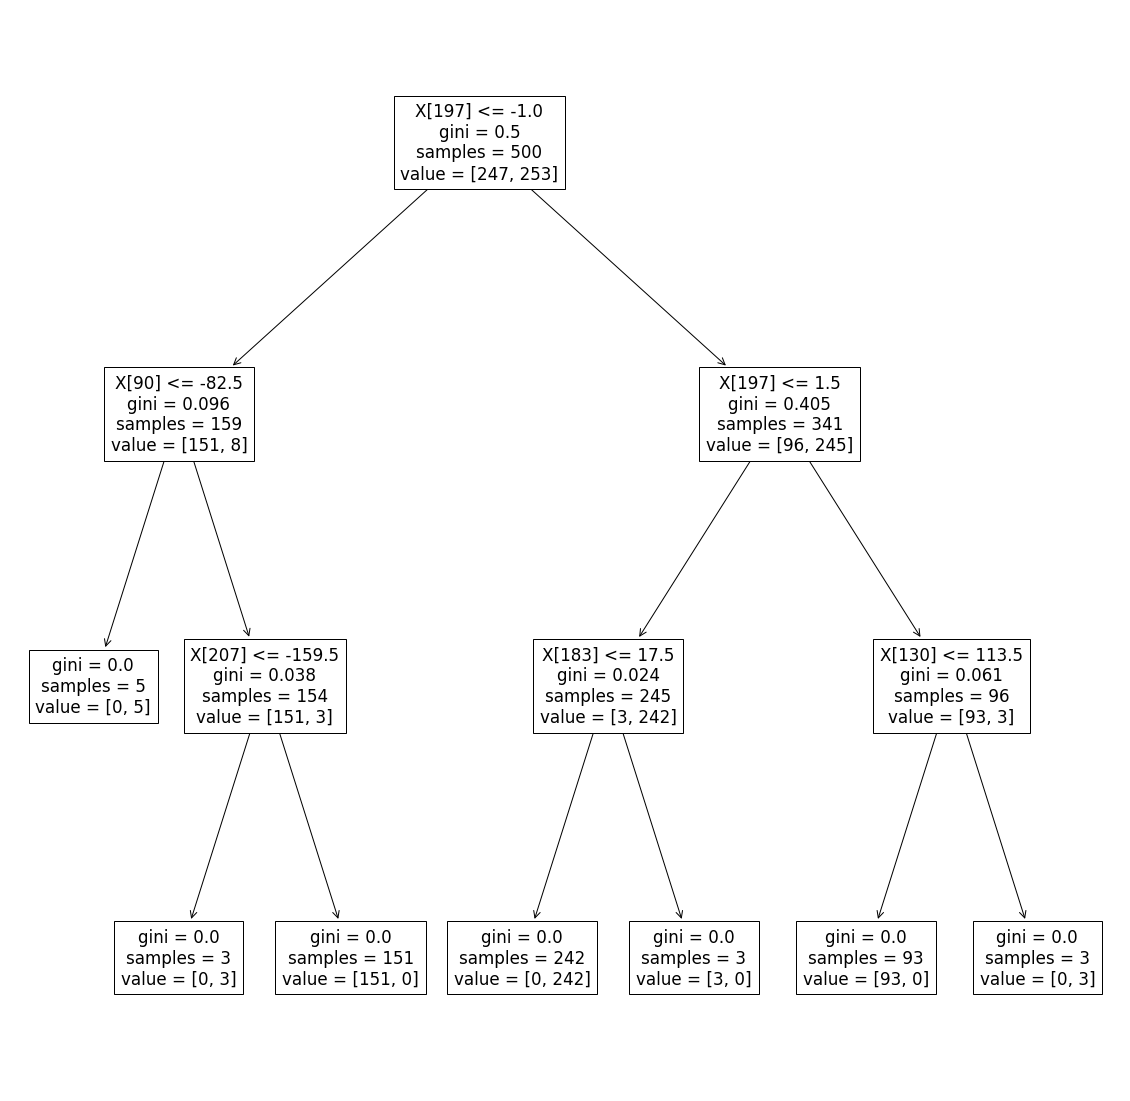

In [18]:
tree.plot_tree(model)
plt.plot(figsize=(10,10))
plt.show()

In [19]:
Y_test[Y_test == 1.0].__len__()/len(Y_test)

0.5371111111111111

In [20]:
r = tree.export_text(model)

In [21]:
print(r)

|--- feature_197 <= -1.00
|   |--- feature_90 <= -82.50
|   |   |--- class: 1.0
|   |--- feature_90 >  -82.50
|   |   |--- feature_207 <= -159.50
|   |   |   |--- class: 1.0
|   |   |--- feature_207 >  -159.50
|   |   |   |--- class: 0.0
|--- feature_197 >  -1.00
|   |--- feature_197 <= 1.50
|   |   |--- feature_183 <= 17.50
|   |   |   |--- class: 1.0
|   |   |--- feature_183 >  17.50
|   |   |   |--- class: 0.0
|   |--- feature_197 >  1.50
|   |   |--- feature_130 <= 113.50
|   |   |   |--- class: 0.0
|   |   |--- feature_130 >  113.50
|   |   |   |--- class: 1.0



In [22]:
df.index[429]

429

In [23]:
df.columns.values[233]

'A1481'

In [24]:
df.columns.values[552]

'A4007'

In [ ]:
def is_prime(n: int):
    for i in range(2,ceil(sqrt(n)),1):
        if n%i == 0:
            return False
    return True

In [ ]:
def is_safe(n: int):
    return is_prime((n-1) // 2) and is_prime(n)

In [25]:
indexes[197]

'A6131'

In [ ]:
numbers = [7103,4007,2999]
for p in numbers:
    print("%d is safe:"%p, is_safe(p))
    print("%d is Sophie Germain:"%p, is_sg(p))
    print("--------------------------")

In [ ]:
model.decision_path()